## 1. Imports and Setup

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style(style="whitegrid")


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Load and Inspect Data

In [4]:
def load_tracking_data(file_path: str, skiprows: int = 1) -> pd.DataFrame:
    """Load tracking data from CSV file, skipping metadata rows if needed."""
    try:
        df = pd.read_csv(file_path, skiprows=skiprows)
        print(f"Loaded data from {file_path} with shape {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return pd.DataFrame()

# Example file path (update as needed)
file_path = os.path.join('positions', '2p5_HA_Mar6', '2p5_HA_6Mar_e_2p5_HA_4 Image 5.csv')
df = load_tracking_data(file_path)

# Preview data
df.head()


Loaded data from positions/2p5_HA_Mar6/2p5_HA_6Mar_e_2p5_HA_4 Image 5.csv with shape (3436, 8)


,Position X,Position Y,Unit,Category,Collection,Time,TrackID,ID
0,117.084000,6.709320,µm,Spot,Position,1,1000001412,1412
1,94.852402,7.493290,µm,Spot,Position,1,1000001540,1540
2,73.360199,17.183701,µm,Spot,Position,1,1000003364,3364
3,141.479004,30.858101,µm,Spot,Position,1,1000005994,5994
4,165.542007,55.057400,µm,Spot,Position,1,1000010624,10624


## 3. Plot Raw Trajectories

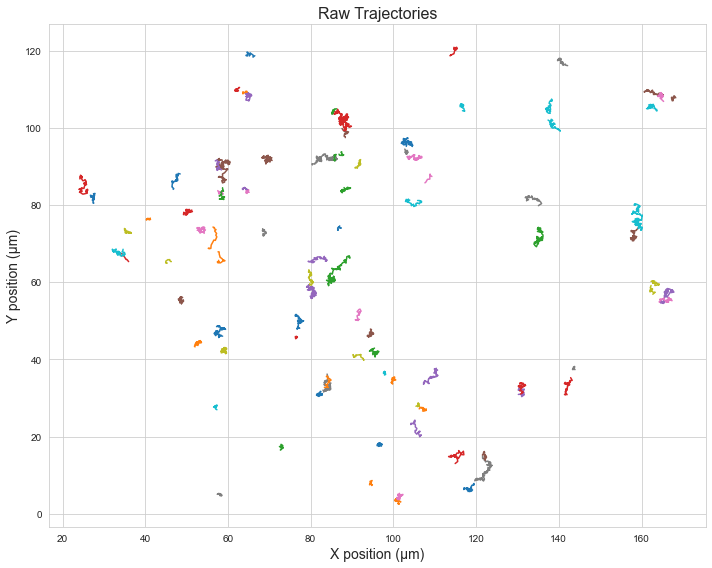

In [ ]:
def plot_trajectories(df: pd.DataFrame, output_path: str = None):
    """Plot all trajectories by TrackID."""
    df_sorted = df.sort_values(by=['TrackID', 'Time'])
    plt.figure(figsize=(10, 8))
    
    for track_id, group in df_sorted.groupby('TrackID'):
        plt.plot(group['Position X'], group['Position Y'], label=f'Track {track_id}')
    
    plt.xlabel('X position (µm)', fontsize=14)
    plt.ylabel('Y position (µm)', fontsize=14)
    plt.title('Raw Trajectories', fontsize=16)
    plt.grid(True)
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, facecolor='white')
    plt.show()

plot_trajectories(df, output_path='output/trajectories_raw.png')


## 4. Translate Trajectories to Origin

In [7]:
def translate_to_origin(track_data: pd.DataFrame) -> pd.DataFrame:
    """Translate a single trajectory so its origin is at (0, 0)."""
    origin_x = track_data['Position X'].iloc[0]
    origin_y = track_data['Position Y'].iloc[0]
    track_data = track_data.copy()
    track_data['Position X'] -= origin_x
    track_data['Position Y'] -= origin_y
    return track_data

def normalize_all_trajectories(df: pd.DataFrame) -> pd.DataFrame:
    """Apply translation to all trajectories by TrackID."""
    return df.groupby('TrackID', group_keys=False).apply(translate_to_origin)

df_translated = normalize_all_trajectories(df)
df_translated.head()


,Position X,Position Y,Unit,Category,Collection,Time,TrackID,ID
0,0.000000,0.00000,µm,Spot,Position,1,1000001412,1412
8,-0.062996,-0.44869,µm,Spot,Position,2,1000001412,24980
17,0.171997,-0.15754,µm,Spot,Position,3,1000001412,47659
28,-0.001999,-0.23963,µm,Spot,Position,4,1000001412,70338
39,0.536003,-0.11506,µm,Spot,Position,5,1000001412,93007


## 5. Plot Normalized Trajectories


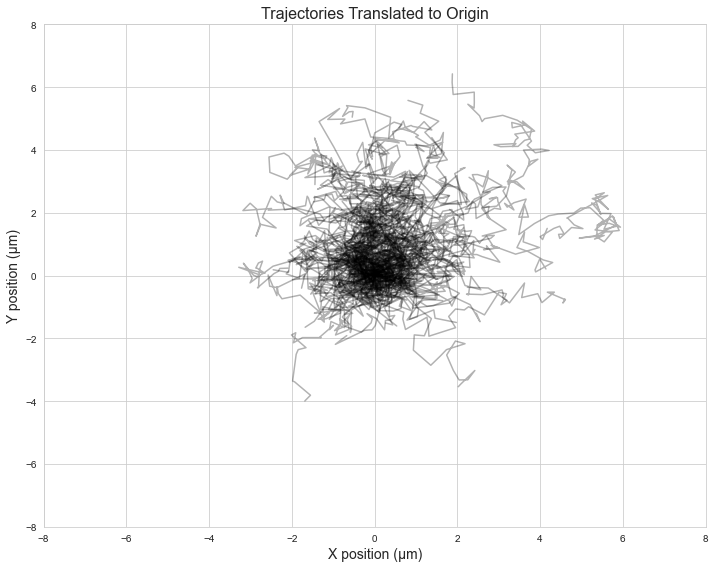

In [11]:
def plot_normalized_trajectories(df: pd.DataFrame, output_path: str = None):
    """Plot all trajectories translated to origin."""
    plt.figure(figsize=(10, 8))
    
    for track_id, group in df.groupby('TrackID'):
        plt.plot(group['Position X'], group['Position Y'], label=f'Track {track_id}', alpha = 0.3, color='black')
    
    plt.xlabel('X position (µm)', fontsize=14)
    plt.ylabel('Y position (µm)', fontsize=14)
    plt.title('Trajectories Translated to Origin', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.xlim([-8,8])
    plt.ylim([-8,8])
    if output_path:
        plt.savefig(output_path, facecolor='white')
    plt.show()

plot_normalized_trajectories(df_translated, output_path='output/trajectories_normalized.png')


## 6. Plot net displacement values

In [12]:
def summarize_tracks(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate summary statistics like displacement and number of steps."""
    summaries = df.groupby('TrackID').agg(
        n_steps=('Time', 'count'),
        x_disp=('Position X', lambda x: x.iloc[-1] - x.iloc[0]),
        y_disp=('Position Y', lambda y: y.iloc[-1] - y.iloc[0])
    )
    summaries['net_displacement'] = (summaries['x_disp']**2 + summaries['y_disp']**2)**0.5
    return summaries

summary_df = summarize_tracks(df_translated)
summary_df.head()


,n_steps,x_disp,y_disp,net_displacement
TrackID,,,,
1000001412,50,2.424004,0.83832,2.564873
1000001540,17,-0.102303,-0.19597,0.221066
1000003364,25,-0.916702,0.23440,0.946196
1000005994,56,1.381989,4.39650,4.608590
1000010624,65,0.844986,2.91470,3.034712


Text(0, 0.5, 'net displacement, µm')

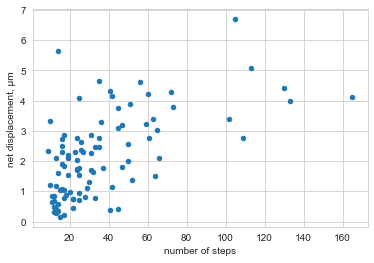

In [24]:
summary_df.plot.scatter(x='n_steps', y = 'net_displacement')
plt.xlabel('number of steps')
plt.ylabel('net displacement, µm')